Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# EVI Forecast on Area of Interest (AOI)
This notebook demonstrates, how to load the model which has been trained using previous notebook, 2_train.ipynb and forecast EVI for next 10 days on new Area of Interest.


### Import Libraries

In [5]:
# Stanadard library imports
import json
import pickle
import os
import sys
import requests
from datetime import datetime,timedelta

# Disable unnecessary logs 
import logging
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings("ignore")

# Third party library imports
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tensorflow import keras

# Local imports
from utils.ard_util import ard_preprocess
from utils.config import farmbeats_config
from utils.constants import CONSTANTS
from utils.satellite_util import SatelliteUtil
from utils.test_helper import get_sat_weather_data
from utils.weather_util import WeatherUtil

# Azure imports
from azure.identity import ClientSecretCredential

# SDK imports
from azure.agrifood.farming import FarmBeatsClient

### Farmbeats Configuration

In [6]:
# FarmBeats Client definition
credential = ClientSecretCredential(
    tenant_id=farmbeats_config['tenant_id'],
    client_id=farmbeats_config['client_id'],
    client_secret=farmbeats_config['client_secret'],
    authority=farmbeats_config['authority']
)

credential_scopes = [farmbeats_config['default_scope']]

fb_client = FarmBeatsClient(
    endpoint=farmbeats_config['instance_url'],
    credential=credential,
    credential_scopes=credential_scopes,
    logging_enable=True
)

### Forecast EVI for new AOI

#### Satellie Data

In [7]:
farmer_id = "contoso_farmer"
boundary_id = "sample-boundary-32" # TODO: Check later for geometry also
bonudary_geometry = '[[-121.5283155441284,38.16172478418468],[-121.51544094085693,38.16172478418468],[-121.51544094085693,38.16791636919515],[-121.5283155441284,38.16791636919515],[-121.5283155441284,38.16172478418468]]'

#TODO: Check if end_dt is not less than current date
end_dt = datetime.strptime(datetime.now().strftime("%Y-%m-%d"), "%Y-%m-%d")
start_dt = end_dt - timedelta(days=60)

In [8]:
# Create Boundary and get satelite and weather (historical and forecast)
get_sat_weather_data(fb_client, 
                farmer_id, 
                boundary_id,
                json.loads(bonudary_geometry), 
                start_dt, 
                end_dt)

# get boundary object
boundary = fb_client.boundaries.get(
            farmer_id=farmer_id,
            boundary_id=boundary_id
        )

Farmer contoso_farmer Exists.
Boundary with id sample-boundary-32 Exist
Queuing satellite job... Submitted Satellite Job
Queuing weather job... Submitted Weather Job
Queuing weather job... Submitted Weather Job
Waiting for all jobs to complete
Succeeded
Succeeded
Succeeded


In [9]:
boundary.as_dict()

{'farmer_id': 'contoso_farmer',
 'geometry': {'coordinates': [[[-121.5283155441284, 38.16172478418468],
    [-121.51544094085693, 38.16172478418468],
    [-121.51544094085693, 38.16791636919515],
    [-121.5283155441284, 38.16791636919515],
    [-121.5283155441284, 38.16172478418468]]],
  'type': 'Polygon'},
 'is_primary': False,
 'acreage': 191.48800387051892,
 'id': 'sample-boundary-32',
 'e_tag': '2b00566d-0000-0600-0000-60a601b50000',
 'created_date_time': '2021-05-20T06:29:09.000Z',
 'modified_date_time': '2021-05-20T06:29:09.000Z',
 'description': 'Created by SDK'}

In [10]:
root_dir = CONSTANTS['root_dir']

sat_links = SatelliteUtil(farmbeats_client = fb_client).download_and_get_sat_file_paths(farmer_id, [boundary], start_dt, end_dt, root_dir)

# get last available data of satellite data
end_dt_w = datetime.strptime(
    sat_links.sceneDateTime.sort_values(ascending=False).values[0][:10], "%Y-%m-%d"
)
# calculate 30 days from last satellite available date
start_dt_w = end_dt_w - timedelta(days=CONSTANTS["input_days"] - 1)

Finished Downloading!


#### Weather Data

In [11]:
# get weather data historical
weather_list = fb_client.weather.list(
            farmer_id=  boundary.farmer_id,
            boundary_id= boundary.id,
            start_date_time=start_dt_w,
            end_date_time=end_dt,
            extension_id=farmbeats_config['weather_provider_extension_id'],
            weather_data_type= "historical", 
            granularity="daily")
weather_data = []
for w_data in weather_list:
    weather_data.append(w_data)
w_df_hist = WeatherUtil.get_weather_data_df(weather_data)

In [12]:
# get weather data forecast
weather_list = fb_client.weather.list(
            farmer_id=  boundary.farmer_id,
            boundary_id= boundary.id,
            start_date_time=end_dt,
            end_date_time=end_dt + timedelta(10),
            extension_id=farmbeats_config['weather_provider_extension_id'], 
            weather_data_type= "forecast", 
            granularity="daily")

weather_data = []
for w_data in weather_list:
    weather_data.append(w_data)
w_df_forecast = WeatherUtil.get_weather_data_df(weather_data)

In [13]:
# merge weather data
weather_df = pd.concat([w_df_hist, w_df_forecast], axis=0, ignore_index=True)

with open(CONSTANTS["w_pkl"], "rb") as f:
    w_parms, weather_mean, weather_std = pickle.load(f)

### Prepare ARD for test boundary

In [14]:
ard = ard_preprocess(
        sat_file_links=sat_links,
        w_df=weather_df,
        sat_res_x=1,
        var_name=CONSTANTS["var_name"],
        interp_date_start=end_dt_w - timedelta(days=60),
        interp_date_end=end_dt_w,
        w_parms=w_parms,
        input_days=CONSTANTS["input_days"],
        output_days=CONSTANTS["output_days"],
        ref_tm=start_dt_w.strftime("%d-%m-%Y"),
        w_mn=weather_mean,
        w_sd=weather_std,
    )

frcst_st_dt  = end_dt_w

In [16]:
# raise exception if ARD is empty
if ard.shape[0] == 0:
    raise Exception("Analysis ready dataset is empty")
# raise exception if data spills into multiple rows
if ard.query("grp1_ > 0").shape[0] > 0:
    raise Exception(
        "More than one record has been found for more than one pixel"
    )
# warning if nans are in input data or data is out of bounds
if (
    ard.query("not nan_input_evi").shape[0] > 0
    or ard.query("not nan_input_w").shape[0] > 0
    or ard.query("not nan_output_w").shape[0] > 0
):
    print("Warning: NaNs found in the input data")
if (
    ard.query(
        "nan_input_evi and nan_input_w and nan_output_w and  not input_evi_le1"
    ).shape[0]
    > 0
):
    print("Warning: input data outside range of (-1,1) found")

### Load Model

In [17]:
# read model and weather normalization stats
model = tf.keras.models.load_model(CONSTANTS["modelh5"], compile=False)

### Model Predictions

In [18]:
# model prediction
label = model.predict(
    [
        np.array(ard.input_evi.to_list()),
        np.array(ard.input_weather.to_list()),
        np.array(ard.forecast_weather.to_list()),
    ]
)
label_names = [
    (frcst_st_dt + timedelta(days=i + 1)).strftime("%Y-%m-%d")
    for i in range(CONSTANTS["output_days"])
]


pred_df = pd.DataFrame(label[:, :, 0], columns=label_names).assign(
    lat=ard.lat_.values, long=ard.long_.values
)

In [ ]:
pred_df.head()

### Write Output to TIF files

In [20]:
%matplotlib inline
import time
from IPython import display
from rasterio.plot import show

output_dir = "results/"
ref_tif = sat_links.filePath.values[0]
with rasterio.open(ref_tif) as src:
    ras_meta = src.profile

,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29,lat,long
0,0.186904,0.278170,0.332766,0.356052,0.363567,0.370310,0.378419,0.378532,0.372499,0.366198,38.167916,-121.528316
1,0.187146,0.278488,0.333110,0.356398,0.363906,0.370638,0.378741,0.378851,0.372812,0.366510,38.167916,-121.528226
2,0.187146,0.278488,0.333110,0.356398,0.363906,0.370638,0.378741,0.378851,0.372812,0.366510,38.167916,-121.528135
3,0.186956,0.278238,0.332839,0.356125,0.363638,0.370378,0.378485,0.378598,0.372563,0.366262,38.167916,-121.528045
4,0.186021,0.276997,0.331490,0.354764,0.362297,0.369079,0.377206,0.377330,0.371318,0.365017,38.167916,-121.527955


In [21]:
for coln in pred_df.columns[:-2]: # Skip last 2 columns: lattiude, longitude
    data_array = np.array(pred_df[coln]).reshape(src.shape)
    with rasterio.open(os.path.join(output_dir, coln + '.tif'), 'w', **ras_meta) as dst:
        dst.write(data_array, indexes=1)

### Visualize EVI Forecast Maps

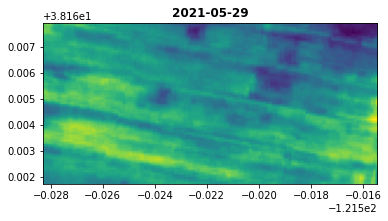

In [22]:
for coln in pred_df.columns[:-2]: # Skip last 2 columns: lattiude, longitude
    src = rasterio.open(os.path.join(output_dir, coln + '.tif'))
    show(src.read(), transform=src.transform, title=coln)
    #show_hist(src)
    display.clear_output(wait=True)
    time.sleep(1)  